In [ ]:
#default_exp data_loading

In [ ]:
#export
import torch
from PIL import Image,ImageFile
from pathlib import Path
from fastai.basics import *
from fastai.vision.data import *
from fastai.vision.all import *
from fastai.text.all import *
Image.LOAD_TRUNCATED_IMAGES=True
ImageFile.LOAD_TRUNCATED_IMAGES=True

In [ ]:
path=Path('../danbooru2020')
image_path=path/'512px/'
meta=path/'meta'

In [ ]:
#with open('named_tags.pkl','rb') as f: named_tags=pickle.load(f)
with open('id_tags.pkl','rb') as f: id_tags=pickle.load(f)
full_table = pd.read_pickle('fulll_table.pkl')

In [ ]:
#I forget why we do this, but needed to be done for dataloader, might be fastai bug? 
#export
@patch
@delegates(TfmdDL.new)
def new(self:SortedDL, dataset=None, **kwargs):
    res = self.res if dataset is None else None
    
    return super(SortedDL, self).new(dataset=dataset, **merge({'res':res}, kwargs))

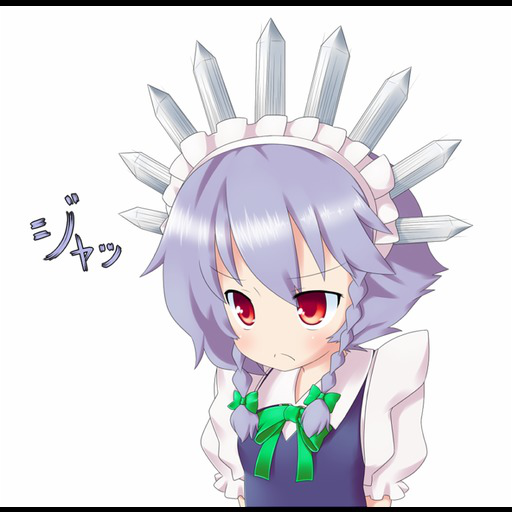

In [ ]:
Image.open(Path('../danbooru2020/512px/0000/400000.jpg'))

In [ ]:
#export
class df_text(Transform):
    def __init__(self,table,id_tags):
        self.table=table
        self.id_tags=id_tags
    def encodes(self,path):
        file_id=int(path.stem)
        tags=L(list(self.table[self.table.id==file_id].tags.item()))
        return [' '.join(tags.shuffle().map(lambda x:self.id_tags[x]).sorted())]
    def decodes(self,text):
        return TitledStr(' '.join(text))

In [ ]:
#export
def get_filtered_image_files(path):
    return get_image_files(path).filter(lambda p:p.stem[-2:]!='_n')

#export
class OpenImage:
    def __init__(self,full_table): self.full_table=full_table
    def __call__(self,path):
        file_id=int(path.stem)
        img=PILImage.create(path)
        width=int(self.full_table[self.full_table.id==file_id].image_width.item())
        height=int(self.full_table[self.full_table.id==file_id].image_height.item())
        pw, ph = img.size 
        if(width>height): dim=(0,(1-height/width)*256,512,256+height/width*256) #images start 512x512 padded
        else: dim=((1-width/height)*256,0,256+width/height*256,512)
        return PILImage(img.crop(dim))

### Should remove uncroppable images from dataset! (w==0 or h==0)

In [ ]:
#export
class BlackCrop(DisplayedTransform):
    split_idx,order = None,-1
    "Danbooru images have a black border added, can read more here: https://www.gwern.net/Danbooru2020"
    def __init__(self, table,  **kwargs):
        store_attr()
        super().__init__(**kwargs)

    def encodes(self, x:(Path)):
        x_id=int(x.stem)
        x=PILImage.create(x)
        entry = self.table[self.table.id==x_id]
        w,h=entry.image_width.item(),entry.image_height.item()
        #should remove uncroppable images from dataset
        if(w==0 or h==0): return PILImage(x)
        if(w>h):
            return PILImage(x.crop((0,256-256*h/w,512,256+256*h/w)))
        else:
            return PILImage(x.crop((256-256*w/h,0,256+256*w/h,512)))
def CropImageBlock(full_table,cls=PILImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=BlackCrop(full_table), batch_tfms=IntToFloatTensor)

#export
def MyImageBlock(fulltable,cls=PILImage,):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=OpenImage(fulltable), batch_tfms=IntToFloatTensor)

In [ ]:
#export
class CropText(Transform):
    order=50
    def __init__(self,max_len=72):
        self.max_len=max_len
    def encodes(self,x:TensorText):
        return retain_type(x[:self.max_len],x)

In [ ]:
#export
class Remove1(Transform):
    def encodes(self,x):
        return next(x)

In [ ]:
#export
def DALLE_dataloader(image_path,full_table,id_tags,bs=64,seq_len=72,max_len=72):
    with open('vocab.pkl','rb') as f: vocab=pickle.load(f)
    tok=SentencePieceTokenizer(max_vocab_sz=2500,sp_model=Path('tmp/spm.model'))
    text_block=TextBlock(tok,vocab=vocab)
    text_block.type_tfms.insert(1,Remove1())
    #text_block.type_tfms.insert(3,CropText())
    dblock = DataBlock(blocks    = (CropImageBlock(full_table),text_block, CategoryBlock),
                   get_items = get_filtered_image_files,
                   get_x     = [lambda x:x,df_text(full_table,id_tags)],
                   get_y     = lambda x:1,
                   splitter  = RandomSplitter(),
                   n_inp=2,
                   item_tfms = [Resize(224),CropText(max_len=max_len)]
                
                  )
    return dblock.dataloaders(image_path, bs=bs, max_len=max_len,seq_len=seq_len,pad_first=False,dl_kwargs=[{'res':range(2575225)},{'res':range(643806)},{}])

Warnings below should be fine as long as they only relate to metadata. 

In [ ]:
#with open('vocab' + '.pkl', 'wb') as f: pickle.dump(list(count.keys()), f, pickle.HIGHEST_PROTOCOL)

In [ ]:
dls=DALLE_dataloader(image_path,full_table,id_tags,max_len=1)

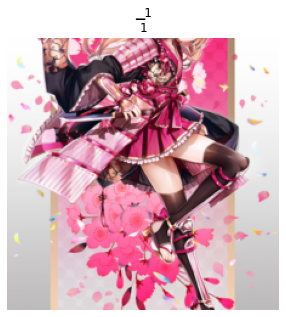

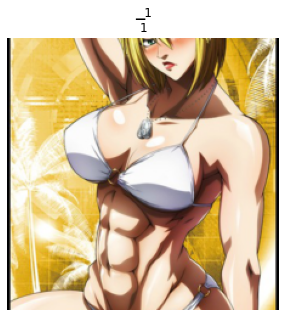

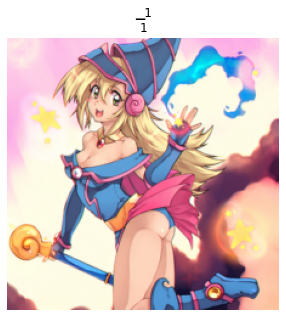

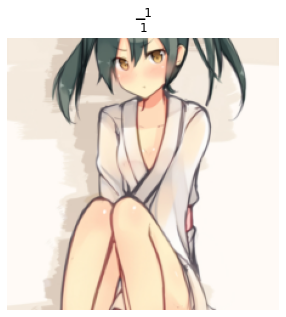

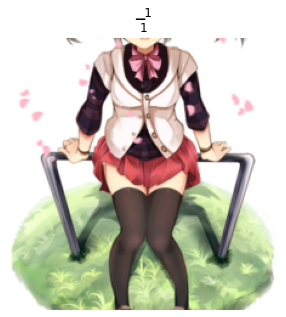

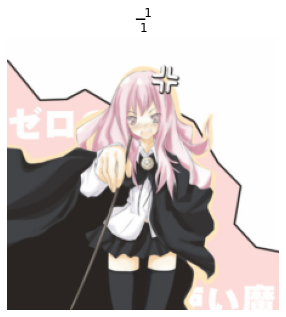

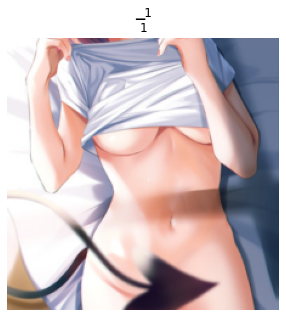

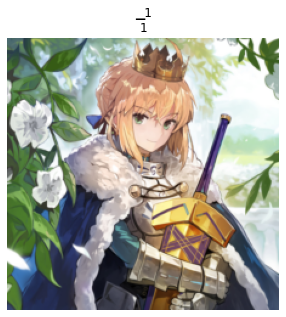

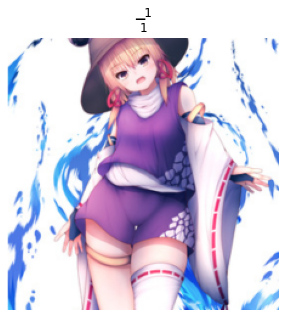

In [ ]:
dls.show_batch()

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted Anki.ipynb.
Converted CLIP.ipynb.
Converted DALLE.ipynb.
Converted DataLoading.ipynb.
Converted Initial-inspection.ipynb.
Converted Reformer-Baseline.ipynb.
Converted Reformer-First-Glance.ipynb.
Converted Reformer.ipynb.
Converted StudyGroup-example.ipynb.
Converted Tokenization-second-try.ipynb.
Converted VAE Reference.ipynb.
Converted VAE.ipynb.
Converted aggregate_image_tags.ipynb.
Converted tags2tokens.ipynb.
